In [1]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import random
from typing import List
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB

import torchaudio

import torch

from torch.utils.data import DataLoader,TensorDataset

import lightning as L

from datasets import Dataset

from pathlib import Path
import multiprocessing

/opt/homebrew/Caskroom/miniforge/base/envs/birdclef/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Preprocess the metadata csv

In [2]:
raw=pd.read_csv('../../data/train_metadata.csv',header=0)

In [3]:
# 1. Check if there are missing values ​​in the `rating` column
# 2. If there are null values, add 0 to fill them in
# 3. After filling in, we randomly assign a value to all the 0 values
# The higher the rating, the better the audio quality

if raw['rating'].isna().sum()>0: # with missing values
    raw['rating'].fillna(0, inplace=True)

# Random assign a value to all places where the value is 0, and select from the specified choices
mask = raw['rating'] == 0  # Create a boolean mask indicating which positions are 0

choices=np.arange(0.5,5.1,0.5).tolist() # [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
random_values = np.random.choice(choices, size=mask.sum())  # Generate random numbers for these 0 values
raw.loc[mask, 'rating'] = random_values  # Fill the generated random numbers back into the corresponding positions of the original DataFrame



In [4]:
len(raw[raw['rating']==0])

0

In [5]:
# Through rating, we calculate the rating of each audio and express it through weight. 
# The purpose of this is to improve the model by increasing the weight of high-quality audio and reducing the weight of low-quality audio.
raw["audio_weight"] = np.clip(raw["rating"] / raw["rating"].max(), 0.1, 1.0)

raw.audio_weight

0        1.0
1        0.5
2        0.5
3        0.8
4        0.8
        ... 
24454    1.0
24455    0.8
24456    0.8
24457    0.9
24458    1.0
Name: audio_weight, Length: 24459, dtype: float64

In [6]:
multiprocessing.cpu_count()

12

In [7]:
# Because this is an unbalanced dataset, the amount of data in each category is very different
# So I will calculate the weight of each category here
# **(-0.5) The purpose is to reduce the relative influence of high-frequency categories and increase the influence of low-frequency categories, 
# so as to help the model better learn those uncommon categories

# Calculate weights and convert to dictionary
sample_weights_dict = (raw['primary_label'].value_counts() / raw['primary_label'].value_counts().sum()) ** (-0.5)
sample_weights_dict = sample_weights_dict.to_dict()

print(sample_weights_dict)


{'zitcis1': 6.994140404653026, 'lirplo': 6.994140404653026, 'litgre1': 6.994140404653026, 'comgre': 6.994140404653026, 'comkin1': 6.994140404653026, 'commoo3': 6.994140404653026, 'comros': 6.994140404653026, 'comsan': 6.994140404653026, 'eaywag1': 6.994140404653026, 'blrwar1': 6.994140404653026, 'houspa': 6.994140404653026, 'eucdov': 6.994140404653026, 'eurcoo': 6.994140404653026, 'hoopoe': 6.994140404653026, 'graher1': 6.994140404653026, 'grywag': 6.994140404653026, 'grewar3': 6.994140404653026, 'grnsan': 6.994140404653026, 'bcnher': 6.994140404653026, 'woosan': 6.994140404653026, 'barswa': 6.994140404653026, 'bkwsti': 6.994140404653026, 'rorpar': 7.631232815588468, 'litegr': 7.77126711628114, 'comtai1': 8.999448106698853, 'grtdro1': 9.379872834345315, 'greegr': 9.41379653579741, 'asikoe2': 9.430896997731349, 'purher1': 9.448090990124102, 'wemhar1': 9.465379368699734, 'kenplo1': 9.500242762483781, 'bkskit1': 9.553267785063618, 'commyn': 10.15886468290476, 'labcro1': 10.202002306597944

### 2. Read ogg data and perform data augmentation and transformation

In [8]:
# Select a single piece of data to operate first

audio_path='../../data/train/asbfly/XC134896.ogg'

In [9]:
# read ogg

def read_audio(path: str):
    """
    Read an OGG file using torchaudio and return the waveform tensor and sample rate.

    Parameters:
        path: Path to the .ogg file

    Returns:
        waveform: Tensor representing the waveform
        sample_rate: Sample rate of the audio file
    """
    audio, sample_rate = torchaudio.load(path)
    return audio, sample_rate


audio,sample_rate=read_audio(path=audio_path)

In [10]:
print(audio)

# change audio tensor to array
print(audio[0].numpy())

print(sample_rate)

tensor([[ 1.3738e-06,  9.2571e-07, -2.7169e-06,  ...,  6.2166e-06,
         -1.4831e-06, -3.4762e-06]])
[ 1.3738349e-06  9.2570565e-07 -2.7168751e-06 ...  6.2165818e-06
 -1.4831421e-06 -3.4762072e-06]
32000


In [11]:
import colorednoise as cn
import numpy as np
import librosa
import torch.nn as nn
class AudioTransform:
    def __init__(self, always_apply=False, p=0.5):
        self.always_apply = always_apply
        self.p = p

    def __call__(self, y: np.ndarray):
        if self.always_apply:
            return self.apply(y)
        else:
            if np.random.rand() < self.p:
                return self.apply(y)
            else:
                return y

    def apply(self, y: np.ndarray):
        raise NotImplementedError


class CustomCompose:
    def __init__(self, transforms: list):
        self.transforms = transforms

    def __call__(self, y: np.ndarray):
        for trns in self.transforms:
            y = trns(y)
        return y


class CustomOneOf:
    def __init__(self, transforms: list, p=1.0):
        self.transforms = transforms
        self.p = p

    def __call__(self, y: np.ndarray):
        if np.random.rand() < self.p:
            n_trns = len(self.transforms)
            trns_idx = np.random.choice(n_trns)
            trns = self.transforms[trns_idx]
            y = trns(y)
        return y


class GaussianNoiseSNR(AudioTransform):
    def __init__(self, always_apply=False, p=0.5, min_snr=5.0, max_snr=40.0, **kwargs):
        super().__init__(always_apply, p)

        self.min_snr = min_snr
        self.max_snr = max_snr

    def apply(self, y: np.ndarray, **params):
        snr = np.random.uniform(self.min_snr, self.max_snr)
        a_signal = np.sqrt(y**2).max()
        a_noise = a_signal / (10 ** (snr / 20))

        white_noise = np.random.randn(len(y))
        a_white = np.sqrt(white_noise**2).max()
        augmented = (y + white_noise * 1 / a_white * a_noise).astype(y.dtype)
        return augmented


class PinkNoiseSNR(AudioTransform):
    def __init__(self, always_apply=False, p=0.5, min_snr=5.0, max_snr=20.0, **kwargs):
        super().__init__(always_apply, p)

        self.min_snr = min_snr
        self.max_snr = max_snr

    def apply(self, y: np.ndarray, **params):
        snr = np.random.uniform(self.min_snr, self.max_snr)
        a_signal = np.sqrt(y**2).max()
        a_noise = a_signal / (10 ** (snr / 20))

        pink_noise = cn.powerlaw_psd_gaussian(1, len(y))
        a_pink = np.sqrt(pink_noise**2).max()
        augmented = (y + pink_noise * 1 / a_pink * a_noise).astype(y.dtype)
        return augmented


class VolumeControl(AudioTransform):
    def __init__(self, always_apply=False, p=0.5, db_limit=10, mode="uniform"):
        super().__init__(always_apply, p)

        assert mode in [
            "uniform",
            "fade",
            "fade",
            "cosine",
            "sine",
        ], "`mode` must be one of 'uniform', 'fade', 'cosine', 'sine'"

        self.db_limit = db_limit
        self.mode = mode

    def apply(self, y: np.ndarray, **params):
        db = np.random.uniform(-self.db_limit, self.db_limit)
        if self.mode == "uniform":
            db_translated = 10 ** (db / 20)
        elif self.mode == "fade":
            lin = np.arange(len(y))[::-1] / (len(y) - 1)
            db_translated = 10 ** (db * lin / 20)
        elif self.mode == "cosine":
            cosine = np.cos(np.arange(len(y)) / len(y) * np.pi * 2)
            db_translated = 10 ** (db * cosine / 20)
        else:
            sine = np.sin(np.arange(len(y)) / len(y) * np.pi * 2)
            db_translated = 10 ** (db * sine / 20)
        augmented = y * db_translated
        return augmented


class NoiseInjection(AudioTransform):
    def __init__(self, always_apply=False, p=0.5, max_noise_level=0.5, sr=32000):
        super().__init__(always_apply, p)

        self.noise_level = (0.0, max_noise_level)
        self.sr = sr

    def apply(self, y: np.ndarray, **params):
        noise_level = np.random.uniform(*self.noise_level)
        noise = np.random.randn(len(y))
        augmented = (y + noise * noise_level).astype(y.dtype)
        return augmented


class GaussianNoise(AudioTransform):
    def __init__(self, always_apply=False, p=0.5, min_snr=5, max_snr=20, sr=32000):
        super().__init__(always_apply, p)

        self.min_snr = min_snr
        self.max_snr = max_snr
        self.sr = sr

    def apply(self, y: np.ndarray, **params):
        snr = np.random.uniform(self.min_snr, self.max_snr)
        a_signal = np.sqrt(y**2).max()
        a_noise = a_signal / (10 ** (snr / 20))

        white_noise = np.random.randn(len(y))
        a_white = np.sqrt(white_noise**2).max()
        augmented = (y + white_noise * 1 / a_white * a_noise).astype(y.dtype)
        return augmented


class PinkNoise(AudioTransform):
    def __init__(self, always_apply=False, p=0.5, min_snr=5, max_snr=20, sr=32000):
        super().__init__(always_apply, p)

        self.min_snr = min_snr
        self.max_snr = max_snr
        self.sr = sr

    def apply(self, y: np.ndarray, **params):
        snr = np.random.uniform(self.min_snr, self.max_snr)
        a_signal = np.sqrt(y**2).max()
        a_noise = a_signal / (10 ** (snr / 20))

        pink_noise = cn.powerlaw_psd_gaussian(1, len(y))
        a_pink = np.sqrt(pink_noise**2).max()
        augmented = (y + pink_noise * 1 / a_pink * a_noise).astype(y.dtype)
        return augmented


class TimeStretch(AudioTransform):
    def __init__(self, always_apply=False, p=0.5, max_rate=1, sr=32000):
        super().__init__(always_apply, p)
        self.max_rate = max_rate
        self.sr = sr

    def apply(self, y: np.ndarray, **params):
        rate = np.random.uniform(0, self.max_rate)
        augmented = librosa.effects.time_stretch(y, rate)
        return augmented


def _db2float(db: float, amplitude=True):
    if amplitude:
        return 10 ** (db / 20)
    else:
        return 10 ** (db / 10)


def volume_down(y: np.ndarray, db: float):
    """
    Low level API for decreasing the volume
    Parameters
    ----------
    y: numpy.ndarray
        stereo / monaural input audio
    db: float
        how much decibel to decrease
    Returns
    -------
    applied: numpy.ndarray
        audio with decreased volume
    """
    applied = y * _db2float(-db)
    return applied


def volume_up(y: np.ndarray, db: float):
    """
    Low level API for increasing the volume
    Parameters
    ----------
    y: numpy.ndarray
        stereo / monaural input audio
    db: float
        how much decibel to increase
    Returns
    -------
    applied: numpy.ndarray
        audio with increased volume
    """
    applied = y * _db2float(db)
    return applied


class RandomVolume(AudioTransform):
    def __init__(self, always_apply=False, p=0.5, limit=10):
        super().__init__(always_apply, p)
        self.limit = limit

    def apply(self, y: np.ndarray, **params):
        db = np.random.uniform(-self.limit, self.limit)
        if db >= 0:
            return volume_up(y, db)
        else:
            return volume_down(y, db)


class CosineVolume(AudioTransform):
    def __init__(self, always_apply=False, p=0.5, limit=10):
        super().__init__(always_apply, p)
        self.limit = limit

    def apply(self, y: np.ndarray, **params):
        db = np.random.uniform(-self.limit, self.limit)
        cosine = np.cos(np.arange(len(y)) / len(y) * np.pi * 2)
        dbs = _db2float(cosine * db)
        return y * dbs


class AddGaussianNoise(AudioTransform):
    """Add gaussian noise to the samples"""

    supports_multichannel = True

    def __init__(
        self, always_apply=False, min_amplitude=0.001, max_amplitude=0.015, p=0.5
    ):
        """
        :param min_amplitude: Minimum noise amplification factor
        :param max_amplitude: Maximum noise amplification factor
        :param p:
        """
        super().__init__(always_apply, p)
        assert min_amplitude > 0.0
        assert max_amplitude > 0.0
        assert max_amplitude >= min_amplitude
        self.min_amplitude = min_amplitude
        self.max_amplitude = max_amplitude

    def apply(self, samples: np.ndarray, sample_rate=32000):
        amplitude = np.random.uniform(self.min_amplitude, self.max_amplitude)
        noise = np.random.randn(*samples.shape).astype(np.float32)
        samples = samples + amplitude * noise
        return samples


class AddGaussianSNR(AudioTransform):
    """
    Add gaussian noise to the input. A random Signal to Noise Ratio (SNR) will be picked
    uniformly in the decibel scale. This aligns with human hearing, which is more
    logarithmic than linear.
    """

    supports_multichannel = True

    def __init__(
        self,
        always_apply=False,
        min_snr_in_db: float = 5.0,
        max_snr_in_db: float = 40.0,
        p: float = 0.5,
    ):
        """
        :param min_snr_in_db: Minimum signal-to-noise ratio in dB. A lower number means more noise.
        :param max_snr_in_db: Maximum signal-to-noise ratio in dB. A greater number means less noise.
        :param p: The probability of applying this transform
        """
        super().__init__(always_apply, p)
        self.min_snr_in_db = min_snr_in_db
        self.max_snr_in_db = max_snr_in_db

    def apply(self, samples: np.ndarray, sample_rate=32000):
        snr = np.random.uniform(self.min_snr_in_db, self.max_snr_in_db)

        clean_rms = np.sqrt(np.mean(np.square(samples)))

        a = float(snr) / 20
        noise_rms = clean_rms / (10**a)

        noise = np.random.normal(0.0, noise_rms, size=samples.shape).astype(np.float32)
        return samples + noise


class Normalize(AudioTransform):
    """
    Apply a constant amount of gain, so that highest signal level present in the sound becomes
    0 dBFS, i.e. the loudest level allowed if all samples must be between -1 and 1. Also known
    as peak normalization.
    """

    supports_multichannel = True

    def __init__(self, always_apply=False, apply_to: str = "all", p: float = 0.5):
        super().__init__(always_apply, p)
        assert apply_to in ("all", "only_too_loud_sounds")
        self.apply_to = apply_to

    def apply(self, samples: np.ndarray, sample_rate=32000):
        max_amplitude = np.amax(np.abs(samples))
        if self.apply_to == "only_too_loud_sounds" and max_amplitude < 1.0:
            return samples

        if max_amplitude > 0:
            return samples / max_amplitude
        else:
            return samples

class NormalizeMelSpec(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.eps = eps

    def forward(self, X):
        mean = X.mean((1, 2), keepdim=True)
        std = X.std((1, 2), keepdim=True)
        Xstd = (X - mean) / (std + self.eps)
        norm_min, norm_max = Xstd.min(-1)[0].min(-1)[0], Xstd.max(-1)[0].max(-1)[0]
        fix_ind = (norm_max - norm_min) > self.eps * torch.ones_like(
            (norm_max - norm_min)
        )
        V = torch.zeros_like(Xstd)
        if fix_ind.sum():
            V_fix = Xstd[fix_ind]
            norm_max_fix = norm_max[fix_ind, None, None]
            norm_min_fix = norm_min[fix_ind, None, None]
            V_fix = torch.max(
                torch.min(V_fix, norm_max_fix),
                norm_min_fix,
            )
            # print(V_fix.shape, norm_min_fix.shape, norm_max_fix.shape)
            V_fix = (V_fix - norm_min_fix) / (norm_max_fix - norm_min_fix)
            V[fix_ind] = V_fix
        return V

In [12]:
np_audio_transforms = CustomCompose(
    [
        CustomOneOf(
            [
                NoiseInjection(p=1, max_noise_level=0.04),
                GaussianNoise(p=1, min_snr=5, max_snr=20),
                PinkNoise(p=1, min_snr=5, max_snr=20),
                AddGaussianNoise(min_amplitude=0.0001, max_amplitude=0.03, p=0.5),
                AddGaussianSNR(min_snr_in_db=5, max_snr_in_db=15, p=0.5),
            ],
            p=0.3,  # It will only choose and apply a transformation 30% of the time. This means that 70% of the time, no transformation will be applied and the audio sample will remain as is. 
            # If you apply this combined transformation multiple times and choose to do nothing most of the time, you will observe that the data appears to be unchanged.
        ),
    ]
)

In [13]:
audio_aug=np_audio_transforms(audio[0].numpy())

In [14]:
audio_aug

array([ 0.01289594,  0.04626923,  0.00062103, ...,  0.03869209,
        0.00367013, -0.00226219], dtype=float32)

In [15]:
audio[0].numpy()

array([ 1.3738349e-06,  9.2570565e-07, -2.7168751e-06, ...,
        6.2165818e-06, -1.4831421e-06, -3.4762072e-06], dtype=float32)

Text(0, 0.5, 'Amplitude')

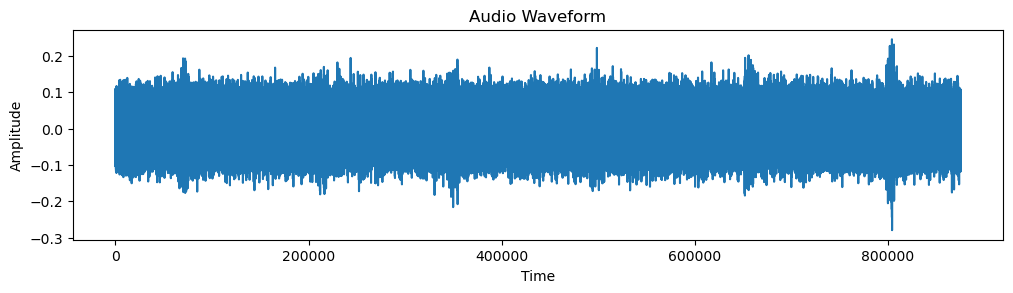

In [16]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(audio_aug)
plt.title('Audio Waveform')
plt.xlabel('Time')
plt.ylabel('Amplitude')

Text(0, 0.5, 'Amplitude')

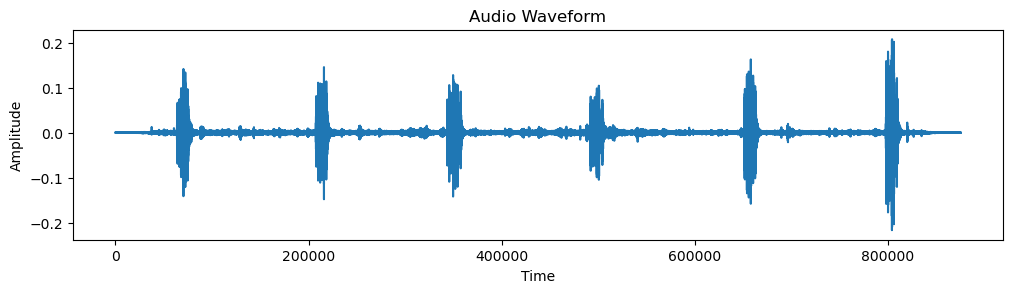

In [17]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1) 
plt.plot(audio[0].numpy())
plt.title('Audio Waveform')
plt.xlabel('Time')
plt.ylabel('Amplitude')

In [31]:
# convert from array to tensor
audio_aug_tensor=torch.from_numpy(audio_aug)
# This method does not copy data, the created tensor will share memory with the original NumPy array. This means that if you modify either one, the other will also be modified.
audio_aug_tensor

tensor([ 0.0129,  0.0463,  0.0006,  ...,  0.0387,  0.0037, -0.0023])

In [32]:
audio_aug_tensor=audio_aug_tensor.unsqueeze(0)
print(audio_aug_tensor)
print(audio_aug_tensor.shape)

tensor([[ 0.0129,  0.0463,  0.0006,  ...,  0.0387,  0.0037, -0.0023]])
torch.Size([1, 875207])


In [20]:
# To create a data iterator that can randomly sample according to the specified weight.
# This is often used to deal with class imbalance problems in data sets, balancing the training process by adjusting the probability of each sample being selected

from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

In [21]:
# we have calculated the weight of each category previously

print(sample_weights_dict)
print(sample_weights_dict.keys())
print(sample_weights_dict.values())

{'zitcis1': 6.994140404653026, 'lirplo': 6.994140404653026, 'litgre1': 6.994140404653026, 'comgre': 6.994140404653026, 'comkin1': 6.994140404653026, 'commoo3': 6.994140404653026, 'comros': 6.994140404653026, 'comsan': 6.994140404653026, 'eaywag1': 6.994140404653026, 'blrwar1': 6.994140404653026, 'houspa': 6.994140404653026, 'eucdov': 6.994140404653026, 'eurcoo': 6.994140404653026, 'hoopoe': 6.994140404653026, 'graher1': 6.994140404653026, 'grywag': 6.994140404653026, 'grewar3': 6.994140404653026, 'grnsan': 6.994140404653026, 'bcnher': 6.994140404653026, 'woosan': 6.994140404653026, 'barswa': 6.994140404653026, 'bkwsti': 6.994140404653026, 'rorpar': 7.631232815588468, 'litegr': 7.77126711628114, 'comtai1': 8.999448106698853, 'grtdro1': 9.379872834345315, 'greegr': 9.41379653579741, 'asikoe2': 9.430896997731349, 'purher1': 9.448090990124102, 'wemhar1': 9.465379368699734, 'kenplo1': 9.500242762483781, 'bkskit1': 9.553267785063618, 'commyn': 10.15886468290476, 'labcro1': 10.202002306597944

In [22]:
sample_weight_values=np.array(list(sample_weights_dict.values()))
sample_weight_values=torch.from_numpy(sample_weight_values)
print(sample_weight_values)
print(sample_weight_values.shape)

tensor([ 6.9941,  6.9941,  6.9941,  6.9941,  6.9941,  6.9941,  6.9941,  6.9941,
         6.9941,  6.9941,  6.9941,  6.9941,  6.9941,  6.9941,  6.9941,  6.9941,
         6.9941,  6.9941,  6.9941,  6.9941,  6.9941,  6.9941,  7.6312,  7.7713,
         8.9994,  9.3799,  9.4138,  9.4309,  9.4481,  9.4654,  9.5002,  9.5533,
        10.1589, 10.2020, 10.2900, 10.4032, 10.4495, 10.5681, 10.6167, 10.7922,
        11.0312, 11.1144, 11.3760, 11.4983, 11.8904, 12.1021, 12.2497, 12.2497,
        12.5618, 12.5618, 12.6437, 12.7695, 13.1243, 13.1707, 13.2651, 13.3616,
        13.4602, 13.8777, 13.9883, 13.9883, 14.0446, 14.1015, 14.1592, 14.1592,
        14.5838, 14.5838, 14.6476, 14.7123, 14.9798, 15.1192, 15.2625, 15.3357,
        15.4853, 15.5618, 15.9619, 15.9619, 16.3052, 16.4853, 16.5777, 16.8644,
        17.5957, 17.5957, 17.8227, 17.9396, 18.0588, 18.5605, 18.6926, 19.1065,
        19.7038, 19.7038, 20.0242, 20.1903, 20.3607, 20.5355, 20.7149, 20.8990,
        20.8990, 20.8990, 21.4823, 21.68

In [23]:
sampler = WeightedRandomSampler(sample_weight_values.type('torch.DoubleTensor'), len(sample_weights_dict.values()),replacement=True)

In [24]:
sampler

In [25]:
# This sampler can be used in dataloader for sampling.
# DataLoader(dataset, batch_size=1, shuffle=False, sampler=None）

In [26]:
# Because if you want to use WeightedRandomSampler, the given weights should be consistent with the number of samples in your dataset, so we need to modify the above operation

sample_weights = (raw['primary_label'].value_counts() / raw['primary_label'].value_counts().sum()) ** (-0.5)

sample_weights

primary_label
zitcis1     6.994140
lirplo      6.994140
litgre1     6.994140
comgre      6.994140
comkin1     6.994140
             ...    
blaeag1    63.847474
wynlau1    63.847474
niwpig1    69.941404
asiope1    69.941404
integr     69.941404
Name: count, Length: 182, dtype: float64

In [27]:
# Map weights to each row of the original data
sample_weights_map = raw['primary_label'].map(sample_weights)

sample_weights_map

0        15.262466
1        15.262466
2        15.262466
3        15.262466
4        15.262466
           ...    
24454     6.994140
24455     6.994140
24456     6.994140
24457     6.994140
24458     6.994140
Name: primary_label, Length: 24459, dtype: float64

In [28]:
# Convert a pandas Series to a NumPy array
sample_weights_np = sample_weights_map.to_numpy(dtype=np.float32)

# Convert NumPy arrays to PyTorch tensors using torch.from_numpy
sample_weights_tensor = torch.from_numpy(sample_weights_np)

In [29]:
#Create a sampler based on the newly obtained weight list
sampler = WeightedRandomSampler(sample_weights_tensor.type('torch.DoubleTensor'), len(sample_weights_tensor),replacement=True)

sampler